# Learning How to Label SpO2 Low Alarms as Suppressible/Not-Suppressible

The underlying idea of Smart Alarm 2.0 is to reduce the number of false SpO2 low alarms produced by pulse oximetry machines. We intend to use some machine learning techniques in order to make a "smart" alarm that can automatically suppress false alarms. A big challenge with ML is that large labeled datasets are scarce and expensive to produce. Hence, here we are using Snorkel's data programming paradigm to design a label model that can label with confidence a dataset of unlabeled SpO2 alarms as suppressible/not-suppressible.

To do this week:
- 

To do eventually:
- [ ] Experiment with prec_init (cant do this until bug patch, see https://github.com/snorkel-team/snorkel/issues/1484)
- [ ] Indicate interval/sampling-rate per patient (e.g., patient 501 has 60sec interval, whereas others have 5sec)
- [ ] Edit excel/csv file for pt 580

In [1]:
from snorkel.labeling.apply.dask import PandasParallelLFApplier
from snorkel.labeling.model.label_model import LabelModel
from snorkel.labeling import labeling_function, LFAnalysis
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from read_chop_data import read_alarms, read_vitals
from compute_mp import apply_compute_mp
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from time import time
import pandas as pd
import numpy as np

In [2]:
pd.set_option("display.max_columns", None)
pd.set_option("display.min_rows", None)

## Loading Data
- **alarms_df**: data for 3,265 SpO2 low alarms from CHOP data
- **vitals_df**: data for vital signs of 100 patients related to the alarms data

(Note: "chop_spo2alarms_df.pkl" and "chop_vitals_df.pkl" can be obtained by running functions defined in /smart-alarm-learning-labels/read_chop_data.py. For "chop_vitals_with_mp_df.pkl", load "chop_vitals_df.pkl" and see [matrix profile](#matrix_profile) cell.)

In [6]:
# For clarity, defining constants for to represent class labels

ABSTAIN = -1
NOT_SUPPRESSIBLE = 0
SUPPRESSIBLE = 1

In [5]:
# Setting global constant to represent sampling rate of 1 data point per 5 seconds in CHOP data

INTERVAL = 5

In [4]:
from os import path

# Read in alarms data
if path.exists("chop_spo2alarms_df.pkl"):
    alarms_df = pd.read_pickle("chop_spo2alarms_df.pkl")
else:
    alarms_df = read_alarms(save=True)

# Read in vitals data
if path.exists("chop_vitals_with_mp_df.pkl"):
    vitals_df = pd.read_pickle("chop_vitals_with_mp_df.pkl")    # CHOP vitals with precomputed matrix profiles
elif path.exists("chop_vitals_df.pkl"):
    temp_vitals_df = pd.read_pickle("chop_vitals_df.pkl")
    vitals_df = apply_compute_mp(vitals_wo_mp_df, ["SPO2-%","HR","RESP"], INTERVAL, save=True, filename="trial.pkl")
else:
    temp_vitals_df = read_vitals(verbose=True, save=True)
    vitals_df = apply_compute_mp(temp_vitals_df, ["SPO2-%","HR","RESP"], INTERVAL, save=True, filename="trial.pkl")

In [7]:
# Set age factors for labeling functions

age_factors_df = pd.DataFrame({"pt_age_group":[1,2,3,4], 
                                "pt_age_group_L":["< 1 month","1-< 2 month","2-< 6 month","6 months and older"], 
                                "hr_age_factor":[3.833, 3.766, 3.733, 3.533], 
                                "rr_age_factor":[0.933, 0.9, 0.866, 0.8]}, 
                                index=[1,2,3,4])

## Define Labeling Functions

In [9]:
# Labeling functions for Snorkel

def get_vitals(pt_id, v_sign, t_start=None, t_end=None):
    """
    Get timeseries of a specific vital sign for a given patient
    
    Args:
        pt_id - integer id of patient
        v_sign - string vital sign name
        t_start - start timestamp 
        t_end - end timestamp
        
    Return:
        timeseries array of vital sign for patient
    """
    return vitals_df.loc[(pt_id, ), v_sign][t_start:t_end]


@labeling_function()
def lf_long_alarm_60s(x):
    """
    If the alarm duration is at least 60 seconds then the alarm is not suppressible, 
    otherwise abstain 
    """
    return NOT_SUPPRESSIBLE if x.duration >= 60 else ABSTAIN


@labeling_function()
def lf_long_alarm_65s(x):
    """
    If the alarm duration is at least 65 seconds then the alarm is not suppressible, 
    otherwise abstain 
    """
    return NOT_SUPPRESSIBLE if x.duration >= 65 else ABSTAIN


@labeling_function()
def lf_long_alarm_70s(x):
    """
    If the alarm duration is at least 70 seconds then the alarm is not suppressible, 
    otherwise abstain 
    """
    return NOT_SUPPRESSIBLE if x.duration >= 70 else ABSTAIN


@labeling_function()
def lf_spo2_below85_over120s(x):
    """
    If SpO2 level stays within range (80,85] for longer than 120 seconds since alarm start 
    then the alarm is not suppressible, otherwise abstain
    """
    spo2 = get_vitals(x.pt_id, "SPO2-%", t_start=x.alarm_datetime, t_end=(x.alarm_datetime + timedelta(seconds=121)))
    return NOT_SUPPRESSIBLE if np.all( (80 < spo2) & (spo2 <= 85) ) else ABSTAIN


@labeling_function()
def lf_spo2_below80_over100s(x):
    """
    If SpO2 level stays within range (70,80] for longer than 100 seconds since alarm start 
    then the alarm is not suppressible, otherwise abstain
    """
    spo2 = get_vitals(x.pt_id, "SPO2-%", t_start=x.alarm_datetime, t_end=(x.alarm_datetime + timedelta(seconds=101)))
    return NOT_SUPPRESSIBLE if np.all( (70 < spo2) & (spo2 <= 80) ) else ABSTAIN


@labeling_function()
def lf_spo2_below70_over90s(x):
    """
    If SpO2 level stays within range (60,70] for longer than 90 seconds since alarm start 
    then the alarm is not suppressible, otherwise abstain
    """
    spo2 = get_vitals(x.pt_id, "SPO2-%", t_start=x.alarm_datetime, t_end=(x.alarm_datetime + timedelta(seconds=91)))
    return NOT_SUPPRESSIBLE if np.all( (60 < spo2) & (spo2 <= 70) ) else ABSTAIN


@labeling_function()
def lf_spo2_below60_over60s(x):
    """
    If SpO2 level stays within range (50,60] for longer than 60 seconds since alarm start 
    then the alarm is not suppressible, otherwise abstain
    """
    spo2 = get_vitals(x.pt_id, "SPO2-%", t_start=x.alarm_datetime, t_end=(x.alarm_datetime + timedelta(seconds=61)))
    return NOT_SUPPRESSIBLE if np.all( (50 < spo2) & (spo2 <= 60) ) else ABSTAIN


@labeling_function()
def lf_spo2_below50_over30s(x):
    """
    If SpO2 level stays within range (0,50] for longer than 30 seconds since alarm start 
    then the alarm is not suppressible, otherwise abstain
    """
    spo2 = get_vitals(x.pt_id, "SPO2-%", t_start=x.alarm_datetime, t_end=(x.alarm_datetime + timedelta(seconds=31)))
    return NOT_SUPPRESSIBLE if np.all( spo2 <= 50 ) else ABSTAIN
    

@labeling_function()
def lf_hr_below50_over120s(x):
    """
    If HR below 50 * age factor for over 120 seconds since alarm start then the alarm is not suppressible, 
    otherwise abstain
    """
    hr = get_vitals(x.pt_id, "HR", t_start=x.alarm_datetime, t_end=(x.alarm_datetime + timedelta(seconds=121)))
    age_factor = age_factors_df.loc[x.pt_age_group, "hr_age_factor"]
    return NOT_SUPPRESSIBLE if np.all( (40*age_factor < hr) & (hr <= 50*age_factor) ) else ABSTAIN
    
    
@labeling_function()
def lf_hr_below40_over60s(x):
    """
    If HR below 40 * age factor for over 60 seconds since alarm start then the alarm is not suppressible, 
    otherwise abstain
    """
    hr = get_vitals(x.pt_id, "HR", t_start=x.alarm_datetime, t_end=(x.alarm_datetime + timedelta(seconds=61)))
    age_factor = age_factors_df.loc[x.pt_age_group, "hr_age_factor"]
    return NOT_SUPPRESSIBLE if np.all( (30*age_factor < hr) & (hr <= 40*age_factor) ) else ABSTAIN


@labeling_function()
def lf_hr_below30(x):
    """
    If HR below 30 * age factor for any duration since alarm start then the alarm is not suppressible, 
    otherwise abstain
    """
    hr = get_vitals(x.pt_id, "HR", t_start=x.alarm_datetime, t_end=(x.alarm_datetime + timedelta(seconds=int(x.duration))))
    age_factor = age_factors_df.loc[x.pt_age_group, "hr_age_factor"]
    return NOT_SUPPRESSIBLE if np.all( hr <= 30*age_factor ) else ABSTAIN


@labeling_function()
def lf_rr_below50_over120s(x):
    """
    If RR below 50 * age factor for over 120 seconds since alarm start then the alarm is not suppressible, 
    otherwise abstain
    """
    rr = get_vitals(x.pt_id, "RESP", t_start=x.alarm_datetime, t_end=(x.alarm_datetime + timedelta(seconds=121)))
    age_factor = age_factors_df.loc[x.pt_age_group, "rr_age_factor"]
    return NOT_SUPPRESSIBLE if np.all( (40*age_factor < rr) & (rr <= 50*age_factor) ) else ABSTAIN


@labeling_function()
def lf_rr_below40_over60s(x):
    """
    If RR below 40 * age factor for over 60 seconds since alarm start then the alarm is not suppressible, 
    otherwise abstain
    """
    rr = get_vitals(x.pt_id, "RESP", t_start=x.alarm_datetime, t_end=(x.alarm_datetime + timedelta(seconds=61)))
    age_factor = age_factors_df.loc[x.pt_age_group, "rr_age_factor"]
    return NOT_SUPPRESSIBLE if np.all( (30*age_factor < rr) & (rr <= 40*age_factor) ) else ABSTAIN


@labeling_function()
def lf_rr_below30(x):
    """
    If RR below 30 * age factor for any duration since alarm start then the alarm is not suppressible, 
    otherwise abstain
    """
    rr = get_vitals(x.pt_id, "RESP", t_start=x.alarm_datetime, t_end=(x.alarm_datetime + timedelta(seconds=int(x.duration))))
    age_factor = age_factors_df.loc[x.pt_age_group, "rr_age_factor"]
    return NOT_SUPPRESSIBLE if np.all( rr <= 30*age_factor ) else ABSTAIN
    
    
def repeat_alarms(x, t):
    """
    If there exists other SpO2 alarms 't' minutes prior to the current alarm's start time and/or
    if there exists other SpO2 alarms 't' minutes after the current alarm's end time then
    the alarm is not suppressible, otherwise abstain

    Args:
        x - alarm instance
        t - timespan to consider (in seconds)
    """
    prior_alarms = alarms_df[ (alarms_df["pt_id"] == x.pt_id) & \
                                (x.alarm_datetime - timedelta(seconds=t) <= alarms_df["alarm_datetime"]) & \
                                (alarms_df["alarm_datetime"] < x.alarm_datetime) ]

    subsq_alarms = alarms_df[ (alarms_df["pt_id"] == x.pt_id) & \
                                (x.alarm_datetime + timedelta(seconds=int(x.duration)) <= alarms_df["alarm_datetime"]) & \
                                (alarms_df["alarm_datetime"] <= x.alarm_datetime + timedelta(seconds=int(x.duration + t))) ]
    
    count = prior_alarms.shape[0] + subsq_alarms.shape[0]
    
    return NOT_SUPPRESSIBLE if count > 0 else ABSTAIN


@labeling_function()
def lf_repeat_alarms_15s(x):
    """
    If there exists other alarms within 15 seconds of the current alarm then the alarm is
    not suppressible, otherwise abstain
    """
    return repeat_alarms(x, 15) 


@labeling_function()
def lf_repeat_alarms_30s(x):
    """
    If there exists other alarms within 30 seconds of the current alarm then the alarm is
    not suppressible, otherwise abstain
    """
    return repeat_alarms(x, 30) 


@labeling_function()
def lf_repeat_alarms_60s(x):
    """
    If there exists other alarms within 60 seconds of the current alarm then the alarm is
    not suppressible, otherwise abstain
    """
    return repeat_alarms(x, 60)


@labeling_function()
def lf_gradual_recovery(x):
    """
    If SpO2 increases at 5-10% per minute after the alarm then the alarm is not suppressible,
    otherwise abstain
    """
    spo2 = get_vitals(x.pt_id, "SPO2-%")
    return ABSTAIN


@labeling_function()
def lf_short_alarm_15s(x):
    """
    If the SpO2-Low alarm duration is at most 15 seconds then the alarm is suppressible, 
    otherwise abstain 
    """
    return SUPPRESSIBLE if x.duration <= 15 else ABSTAIN


@labeling_function()
def lf_short_alarm_10s(x):
    """
    If the SpO2-Low alarm duration is at most 10 seconds then the alarm is suppressible, 
    otherwise abstain 
    """
    return SUPPRESSIBLE if x.duration <= 10 else ABSTAIN


@labeling_function()
def lf_short_alarm_5s(x):
    """
    If the SpO2-Low alarm duration is at most 5 seconds then the alarm is suppressible, 
    otherwise abstain 
    """
    return SUPPRESSIBLE if x.duration <= 5 else ABSTAIN


def max_recovery(data):
    """
    Determine the maximum recovery between two consecutive data points in given data
    
    Args:
        data - array of numeric measurements
        
    Return:
        float - maximum recovery
    """
    r = []
    
    for i in range(len(data)):
        for j in range(i+1, len(data)):
            r.append(data[j] - data[i])
            
    return max(r)


@labeling_function()
def lf_immediate_recovery_10s(x):
    """
    If SpO2 level increases/recovers by more than 20 percentage points within 
    10 seconds of alarm start then the alarm is suppressible, otherwise abstain
    """
    spo2 = get_vitals(x.pt_id, "SPO2-%", t_start=x.alarm_datetime, t_end=(x.alarm_datetime + timedelta(seconds=10)))
    if len(spo2) < 2:
        return ABSTAIN
    return SUPPRESSIBLE if max_recovery(spo2) > 20 else ABSTAIN


@labeling_function()
def lf_immediate_recovery_15s(x):
    """
    If SpO2 level increases/recovers by more than 30 percentage points within 
    15 seconds of alarm start then the alarm is suppressible, otherwise abstain
    """
    spo2 = get_vitals(x.pt_id, "SPO2-%", t_start=x.alarm_datetime, t_end=(x.alarm_datetime + timedelta(seconds=15)))
    if len(spo2) < 2:
        return ABSTAIN
    return SUPPRESSIBLE if max_recovery(spo2) > 30 else ABSTAIN


@labeling_function()
def lf_hr_tech_err_20(x):
    """
    If the difference between the SpO2 HR and ECG HR is larger than 20 percentage points 
    at time of alarm then suppressible, otherwise abstain
    """
    spo2_hr = get_vitals(x.pt_id, "SPO2-R")
    ecg_hr = get_vitals(x.pt_id, "HR")
    return SUPPRESSIBLE if abs(spo2_hr[x.alarm_datetime] - ecg_hr[x.alarm_datetime]) > 20 else ABSTAIN


@labeling_function()
def lf_hr_tech_err_30(x):
    """
    If the difference between the SpO2 HR and ECG HR is larger than 30 percentage points 
    at time of alarm then suppressible, otherwise abstain
    """
    spo2_hr = get_vitals(x.pt_id, "SPO2-R")
    ecg_hr = get_vitals(x.pt_id, "HR")
    return SUPPRESSIBLE if abs(spo2_hr[x.alarm_datetime] - ecg_hr[x.alarm_datetime]) > 30 else ABSTAIN


@labeling_function()
def lf_outlier_spo2_120(x):
    """
    If there exists an outlier (spike in matrix profile larger than 8.4) in the 
    120 second window surrounding the time of alarm then suppressible, otherwise abstain
    """
    spo2 = get_vitals(x.pt_id, 
                      "SPO2-% MP120",
                      t_start=(x.alarm_datetime - timedelta(seconds=60)),
                      t_end=(x.alarm_datetime + timedelta(seconds=60)) )
    return SUPPRESSIBLE if np.any( spo2 > 8.4 ) else ABSTAIN


@labeling_function()
def lf_outlier_spo2_110(x):
    """
    If there exists an outlier (spike in matrix profile larger than 7.8) in the 
    110 second window surrounding the time of alarm then suppressible, otherwise abstain
    """
    spo2 = get_vitals(x.pt_id, 
                      "SPO2-% MP110",
                      t_start=(x.alarm_datetime - timedelta(seconds=55)),
                      t_end=(x.alarm_datetime + timedelta(seconds=55)) )
    return SUPPRESSIBLE if np.any( spo2 > 7.8 ) else ABSTAIN


@labeling_function()
def lf_outlier_spo2_100(x):
    """
    If there exists an outlier (spike in matrix profile larger than 7.2) in the 
    100 second window surrounding the time of alarm then suppressible, otherwise abstain
    """
    spo2 = get_vitals(x.pt_id, 
                      "SPO2-% MP100",
                      t_start=(x.alarm_datetime - timedelta(seconds=50)),
                      t_end=(x.alarm_datetime + timedelta(seconds=50)) )
    return SUPPRESSIBLE if np.any( spo2 > 7.2 ) else ABSTAIN


@labeling_function()
def lf_outlier_spo2_90(x):
    """
    If there exists an outlier (spike in matrix profile larger than 6.6) in the 
    90 second window surrounding the time of alarm then suppressible, otherwise abstain
    """
    spo2 = get_vitals(x.pt_id, 
                      "SPO2-% MP90",
                      t_start=(x.alarm_datetime - timedelta(seconds=45)),
                      t_end=(x.alarm_datetime + timedelta(seconds=45)) )
    return SUPPRESSIBLE if np.any( spo2 > 6.6 ) else ABSTAIN


@labeling_function()
def lf_outlier_spo2_80(x):
    """
    If there exists an outlier (spike in matrix profile larger than 6.0) in the 
    80 second window surrounding the time of alarm then suppressible, otherwise abstain
    """
    spo2 = get_vitals(x.pt_id, 
                      "SPO2-% MP80",
                      t_start=(x.alarm_datetime - timedelta(seconds=40)),
                      t_end=(x.alarm_datetime + timedelta(seconds=40)) )
    return SUPPRESSIBLE if np.any( spo2 > 6.0 ) else ABSTAIN


@labeling_function()
def lf_outlier_spo2_70(x):
    """
    If there exists an outlier (spike in matrix profile larger than 5.3) in the 
    70 second window surrounding the time of alarm then suppressible, otherwise abstain
    """
    spo2 = get_vitals(x.pt_id, 
                      "SPO2-% MP70",
                      t_start=(x.alarm_datetime - timedelta(seconds=35)),
                      t_end=(x.alarm_datetime + timedelta(seconds=35)) )
    return SUPPRESSIBLE if np.any( spo2 > 5.3 ) else ABSTAIN


@labeling_function()
def lf_outlier_spo2_60(x):
    """
    If there exists an outlier (spike in matrix profile larger than 4.6) in the 
    60 second window surrounding the time of alarm then suppressible, otherwise abstain
    """
    spo2 = get_vitals(x.pt_id, 
                      "SPO2-% MP60",
                      t_start=(x.alarm_datetime - timedelta(seconds=30)),
                      t_end=(x.alarm_datetime + timedelta(seconds=30)) )
    return SUPPRESSIBLE if np.any( spo2 > 4.6 ) else ABSTAIN


@labeling_function()
def lf_outlier_spo2_50(x):
    """
    If there exists an outlier (spike in matrix profile larger than 3.8) in the 
    50 second window surrounding the time of alarm then suppressible, otherwise abstain
    """
    spo2 = get_vitals(x.pt_id, 
                      "SPO2-% MP50",
                      t_start=(x.alarm_datetime - timedelta(seconds=25)),
                      t_end=(x.alarm_datetime + timedelta(seconds=25)) )
    return SUPPRESSIBLE if np.any( spo2 > 3.8 ) else ABSTAIN


@labeling_function()
def lf_outlier_spo2_40(x):
    """
    If there exists an outlier (spike in matrix profile larger than 2.9) in the 
    40 second window surrounding the time of alarm then suppressible, otherwise abstain
    """
    spo2 = get_vitals(x.pt_id, 
                      "SPO2-% MP40",
                      t_start=(x.alarm_datetime - timedelta(seconds=20)),
                      t_end=(x.alarm_datetime + timedelta(seconds=20)) )
    return SUPPRESSIBLE if np.any( spo2 > 2.9 ) else ABSTAIN


@labeling_function()
def lf_outlier_spo2_30(x):
    """
    If there exists an outlier (spike in matrix profile larger than 2.1) in the 
    30 second window surrounding the time of alarm then suppressible, otherwise abstain
    """
    spo2 = get_vitals(x.pt_id, 
                      "SPO2-% MP30",
                      t_start=(x.alarm_datetime - timedelta(seconds=15)),
                      t_end=(x.alarm_datetime + timedelta(seconds=15)) )
    return SUPPRESSIBLE if np.any( spo2 > 2.1 ) else ABSTAIN


@labeling_function()
def lf_outlier_spo2_20(x):
    """
    If there exists an outlier (spike in matrix profile larger than 1.0) in the 
    20 second window surrounding the time of alarm then suppressible, otherwise abstain
    """
    spo2 = get_vitals(x.pt_id, 
                      "SPO2-% MP20",
                      t_start=(x.alarm_datetime - timedelta(seconds=10)),
                      t_end=(x.alarm_datetime + timedelta(seconds=10)) )
    return SUPPRESSIBLE if np.any( spo2 > 1.0 ) else ABSTAIN


@labeling_function()
def lf_outlier_hr_120(x):
    """
    If there exists at least one data point where the 120-second window heart rate matrix profile
    exceeds 9.0 within a 120-second window surrounding the alarm then the alarm is suppressible, 
    otherwise abstain
    """
    hr_mp = get_vitals(x.pt_id, 
                       "HR MP120",
                       t_start=(x.alarm_datetime - timedelta(seconds=60)),
                       t_end=(x.alarm_datetime + timedelta(seconds=60)) )
    return SUPPRESSIBLE if np.any( hr_mp > 9.0 ) else ABSTAIN


@labeling_function()
def lf_outlier_hr_110(x):
    """
    If there exists at least one data point where the 110-second window heart rate matrix profile
    exceeds 8.5 within a 110-second window surrounding the alarm then the alarm is suppressible, 
    otherwise abstain
    """
    hr_mp = get_vitals(x.pt_id, 
                       "HR MP110",
                       t_start=(x.alarm_datetime - timedelta(seconds=55)),
                       t_end=(x.alarm_datetime + timedelta(seconds=55)) )
    return SUPPRESSIBLE if np.any( hr_mp > 8.5 ) else ABSTAIN


@labeling_function()
def lf_outlier_hr_100(x):
    """
    If there exists at least one data point where the 100-second window heart rate matrix profile
    exceeds 7.8 within a 100-second window surrounding the alarm then the alarm is suppressible, 
    otherwise abstain
    """
    hr_mp = get_vitals(x.pt_id, 
                       "HR MP100",
                       t_start=(x.alarm_datetime - timedelta(seconds=50)),
                       t_end=(x.alarm_datetime + timedelta(seconds=50)) )
    return SUPPRESSIBLE if np.any( hr_mp > 7.8 ) else ABSTAIN


@labeling_function()
def lf_outlier_hr_90(x):
    """
    If there exists at least one data point where the 90-second window heart rate matrix profile
    exceeds 7.3 within a 90-second window surrounding the alarm then the alarm is suppressible, 
    otherwise abstain
    """
    hr_mp = get_vitals(x.pt_id, 
                       "HR MP90",
                       t_start=(x.alarm_datetime - timedelta(seconds=45)),
                       t_end=(x.alarm_datetime + timedelta(seconds=45)) )
    return SUPPRESSIBLE if np.any( hr_mp > 7.3 ) else ABSTAIN


@labeling_function()
def lf_outlier_hr_80(x):
    """
    If there exists at least one data point where the 80-second window heart rate matrix profile
    exceeds 6.7 within a 80-second window surrounding the alarm then the alarm is suppressible, 
    otherwise abstain
    """
    hr_mp = get_vitals(x.pt_id, 
                       "HR MP80",
                       t_start=(x.alarm_datetime - timedelta(seconds=40)),
                       t_end=(x.alarm_datetime + timedelta(seconds=40)) )
    return SUPPRESSIBLE if np.any( hr_mp > 6.7 ) else ABSTAIN


@labeling_function()
def lf_outlier_hr_70(x):
    """
    If there exists at least one data point where the 70-second window heart rate matrix profile
    exceeds 6.0 within a 70-second window surrounding the alarm then the alarm is suppressible, 
    otherwise abstain
    """
    hr_mp = get_vitals(x.pt_id, 
                       "HR MP70",
                       t_start=(x.alarm_datetime - timedelta(seconds=35)),
                       t_end=(x.alarm_datetime + timedelta(seconds=35)) )
    return SUPPRESSIBLE if np.any( hr_mp > 6.0 ) else ABSTAIN


@labeling_function()
def lf_outlier_hr_60(x):
    """
    If there exists at least one data point where the 60-second window heart rate matrix profile
    exceeds 5.4 within a 60-second window surrounding the alarm then the alarm is suppressible, 
    otherwise abstain
    """
    hr_mp = get_vitals(x.pt_id, 
                       "HR MP60",
                       t_start=(x.alarm_datetime - timedelta(seconds=30)),
                       t_end=(x.alarm_datetime + timedelta(seconds=30)) )
    return SUPPRESSIBLE if np.any( hr_mp > 5.4 ) else ABSTAIN


@labeling_function()
def lf_outlier_hr_50(x):
    """
    If there exists at least one data point where the 50-second window heart rate matrix profile
    exceeds 4.7 within a 50-second window surrounding the alarm then the alarm is suppressible, 
    otherwise abstain
    """
    hr_mp = get_vitals(x.pt_id, 
                       "HR MP50",
                       t_start=(x.alarm_datetime - timedelta(seconds=25)),
                       t_end=(x.alarm_datetime + timedelta(seconds=25)) )
    return SUPPRESSIBLE if np.any( hr_mp > 4.7 ) else ABSTAIN


@labeling_function()
def lf_outlier_hr_40(x):
    """
    If there exists at least one data point where the 40-second window heart rate matrix profile
    exceeds 3.9 within a 40-second window surrounding the alarm then the alarm is suppressible, 
    otherwise abstain
    """
    hr_mp = get_vitals(x.pt_id, 
                       "HR MP40",
                       t_start=(x.alarm_datetime - timedelta(seconds=20)),
                       t_end=(x.alarm_datetime + timedelta(seconds=20)) )
    return SUPPRESSIBLE if np.any( hr_mp > 3.9 ) else ABSTAIN


@labeling_function()
def lf_outlier_hr_30(x):
    """
    If there exists at least one data point where the 30-second window heart rate matrix profile
    exceeds 3.1 within a 30-second window surrounding the alarm then the alarm is suppressible, 
    otherwise abstain
    """
    hr_mp = get_vitals(x.pt_id, 
                       "HR MP30",
                       t_start=(x.alarm_datetime - timedelta(seconds=15)),
                       t_end=(x.alarm_datetime + timedelta(seconds=15)) )
    return SUPPRESSIBLE if np.any( hr_mp > 3.1 ) else ABSTAIN


@labeling_function()
def lf_outlier_hr_20(x):
    """
    If there exists at least one data point where the 20-second window heart rate matrix profile
    exceeds 2.1 within a 20-second window surrounding the alarm then the alarm is suppressible, 
    otherwise abstain
    """
    hr_mp = get_vitals(x.pt_id, 
                       "HR MP20",
                       t_start=(x.alarm_datetime - timedelta(seconds=10)),
                       t_end=(x.alarm_datetime + timedelta(seconds=10)) )
    return SUPPRESSIBLE if np.any( hr_mp > 2.1 ) else ABSTAIN


@labeling_function()
def lf_outlier_rr_120(x):
    """
    If there exists at least one data point where the 120-second window respiratory rate matrix profile
    exceeds 8.7 within a 120-second window surrounding the alarm then the alarm is suppressible, 
    otherwise abstain
    """
    rr_mp = get_vitals(x.pt_id, 
                       "RESP MP120",
                       t_start=(x.alarm_datetime - timedelta(seconds=60)),
                       t_end=(x.alarm_datetime + timedelta(seconds=60)) )
    return SUPPRESSIBLE if np.any( rr_mp > 8.7 ) else ABSTAIN


@labeling_function()
def lf_outlier_rr_110(x):
    """
    If there exists at least one data point where the 110-second window respiratory rate matrix profile
    exceeds 8.1 within a 110-second window surrounding the alarm then the alarm is suppressible, 
    otherwise abstain
    """
    rr_mp = get_vitals(x.pt_id, 
                       "RESP MP110",
                       t_start=(x.alarm_datetime - timedelta(seconds=55)),
                       t_end=(x.alarm_datetime + timedelta(seconds=55)))
    return SUPPRESSIBLE if np.any( rr_mp > 8.1 ) else ABSTAIN


@labeling_function()
def lf_outlier_rr_100(x):
    """
    If there exists at least one data point where the 100-second window respiratory rate matrix profile
    exceeds 7.6 within a 100-second window surrounding the alarm then the alarm is suppressible, 
    otherwise abstain
    """
    rr_mp = get_vitals(x.pt_id, 
                       "RESP MP100",
                       t_start=(x.alarm_datetime - timedelta(seconds=50)),
                       t_end=(x.alarm_datetime + timedelta(seconds=50)) )
    return SUPPRESSIBLE if np.any( rr_mp > 7.6 ) else ABSTAIN


@labeling_function()
def lf_outlier_rr_90(x):
    """
    If there exists at least one data point where the 90-second window respiratory rate matrix profile
    exceeds 7.1 within a 90-second window surrounding the alarm then the alarm is suppressible, 
    otherwise abstain
    """
    rr_mp = get_vitals(x.pt_id, 
                       "RESP MP90",
                       t_start=(x.alarm_datetime - timedelta(seconds=45)),
                       t_end=(x.alarm_datetime + timedelta(seconds=45)) )
    return SUPPRESSIBLE if np.any( rr_mp > 7.1 ) else ABSTAIN


@labeling_function()
def lf_outlier_rr_80(x):
    """
    If there exists at least one data point where the 80-second window respiratory rate matrix profile
    exceeds 6.5 within a 80-second window surrounding the alarm then the alarm is suppressible, 
    otherwise abstain
    """
    rr_mp = get_vitals(x.pt_id, 
                       "RESP MP80",
                       t_start=(x.alarm_datetime - timedelta(seconds=40)),
                       t_end=(x.alarm_datetime + timedelta(seconds=40)) )
    return SUPPRESSIBLE if np.any( rr_mp > 6.5 ) else ABSTAIN


@labeling_function()
def lf_outlier_rr_70(x):
    """
    If there exists at least one data point where the 70-second window respiratory rate matrix profile
    exceeds 6.0 within a 70-second window surrounding the alarm then the alarm is suppressible, 
    otherwise abstain
    """
    rr_mp = get_vitals(x.pt_id, 
                       "RESP MP70",
                       t_start=(x.alarm_datetime - timedelta(seconds=35)),
                       t_end=(x.alarm_datetime + timedelta(seconds=35)) )
    return SUPPRESSIBLE if np.any( rr_mp > 6.0 ) else ABSTAIN


@labeling_function()
def lf_outlier_rr_60(x):
    """
    If there exists at least one data point where the 60-second window respiratory rate matrix profile
    exceeds 5.4 within a 60-second window surrounding the alarm then the alarm is suppressible, 
    otherwise abstain
    """
    rr_mp = get_vitals(x.pt_id, 
                       "RESP MP60",
                       t_start=(x.alarm_datetime - timedelta(seconds=30)),
                       t_end=(x.alarm_datetime + timedelta(seconds=30)) )
    return SUPPRESSIBLE if np.any( rr_mp > 5.4 ) else ABSTAIN


@labeling_function()
def lf_outlier_rr_50(x):
    """
    If there exists at least one data point where the 50-second window respiratory rate matrix profile
    exceeds 4.7 within a 50-second window surrounding the alarm then the alarm is suppressible, 
    otherwise abstain
    """
    rr_mp = get_vitals(x.pt_id, 
                       "RESP MP50",
                       t_start=(x.alarm_datetime - timedelta(seconds=25)),
                       t_end=(x.alarm_datetime + timedelta(seconds=25)) )
    return SUPPRESSIBLE if np.any( rr_mp > 4.7 ) else ABSTAIN


@labeling_function()
def lf_outlier_rr_40(x):
    """
    If there exists at least one data point where the 40-second window respiratory rate matrix profile
    exceeds 3.9 within a 40-second window surrounding the alarm then the alarm is suppressible, 
    otherwise abstain
    """
    rr_mp = get_vitals(x.pt_id, 
                       "RESP MP40",
                       t_start=(x.alarm_datetime - timedelta(seconds=20)),
                       t_end=(x.alarm_datetime + timedelta(seconds=20)) )
    return SUPPRESSIBLE if np.any( rr_mp > 3.9 ) else ABSTAIN


@labeling_function()
def lf_outlier_rr_30(x):
    """
    If there exists at least one data point where the 30-second window respiratory rate matrix profile
    exceeds 3.0 within a 30-second window surrounding the alarm then the alarm is suppressible, 
    otherwise abstain
    """
    rr_mp = get_vitals(x.pt_id, 
                       "RESP MP30",
                       t_start=(x.alarm_datetime - timedelta(seconds=15)),
                       t_end=(x.alarm_datetime + timedelta(seconds=15)) )
    return SUPPRESSIBLE if np.any( rr_mp > 3.0 ) else ABSTAIN


@labeling_function()
def lf_outlier_rr_20(x):
    """
    If there exists at least one data point where the 20-second window respiratory rate matrix profile
    exceeds 2.0 within a 20-second window surrounding the alarm then the alarm is suppressible, 
    otherwise abstain
    """
    rr_mp = get_vitals(x.pt_id, 
                       "RESP MP20",
                       t_start=(x.alarm_datetime - timedelta(seconds=10)),
                       t_end=(x.alarm_datetime + timedelta(seconds=10)) )
    return SUPPRESSIBLE if np.any( rr_mp > 2.0 ) else ABSTAIN




## Apply Labeling Functions to the Data

In [10]:
# Define set of LFs to use in the model

lfs = [
        lf_long_alarm_60s, lf_long_alarm_65s, lf_long_alarm_70s,
        lf_spo2_below85_over120s, lf_spo2_below80_over100s, lf_spo2_below70_over90s, lf_spo2_below60_over60s, lf_spo2_below50_over30s,
        lf_hr_below50_over120s, lf_hr_below40_over60s, lf_hr_below30,
        lf_rr_below50_over120s, lf_rr_below40_over60s, lf_rr_below30,
        lf_repeat_alarms_15s, lf_repeat_alarms_30s, lf_repeat_alarms_60s,
        lf_short_alarm_15s, lf_short_alarm_10s, lf_short_alarm_5s,
        lf_immediate_recovery_10s, lf_immediate_recovery_15s,
        lf_hr_tech_err_20, lf_hr_tech_err_30,
        lf_outlier_spo2_120, lf_outlier_spo2_110, lf_outlier_spo2_100, lf_outlier_spo2_90, lf_outlier_spo2_80, lf_outlier_spo2_70, lf_outlier_spo2_60, lf_outlier_spo2_50, lf_outlier_spo2_40, lf_outlier_spo2_30, lf_outlier_spo2_20,
        lf_outlier_hr_120, lf_outlier_hr_110, lf_outlier_hr_100, lf_outlier_hr_90, lf_outlier_hr_80, lf_outlier_hr_70, lf_outlier_hr_60, lf_outlier_hr_50, lf_outlier_hr_40, lf_outlier_hr_30, lf_outlier_hr_20,
        lf_outlier_rr_120, lf_outlier_rr_110, lf_outlier_rr_100, lf_outlier_rr_90, lf_outlier_rr_80, lf_outlier_rr_70, lf_outlier_rr_60, lf_outlier_rr_50, lf_outlier_rr_40, lf_outlier_rr_30, lf_outlier_rr_20
    ]

In [ ]:
# LF application takes approx 25 minutes on Ash

start_time = time()
applier = PandasParallelLFApplier(lfs)
L_alarms = applier.apply(alarms_df, n_parallel=10, scheduler="threads", fault_tolerant=True)
print("Elapsed time: ", time() - start_time)

In [11]:
#np.save("L_alarms.npy", L_alarms)
#L_alarms = np.load("L_alarms.npy")

## Learn a Label Model
Snorkel v0.9.5 builds a model from the conditional probabilities of the LFs (under the assumuption that they are conditionally independent) and iteratively re-weights and combines the output labels. 

For evaluation, we consider the following metrics:
- suppress - percentage of predictions that are a SUPPRESSIBLE label
- abstain - percentage of predictions for which the model abstained
- accuracy - percentage of predictions the model got correct
- coverage - percentage of the dataset that the model produced a label
- precision - percentage of positive predictions that actually have positive labels
- recall - percentage of positive examples that are predicted correctly
- F1 - harmonic mean of recall and precision
- ROC AUC - area under the ROC curve

In [29]:
# Uncomment this if you want to see the loss from the label model fit
#import logging
#logging.basicConfig(level=logging.INFO)

### 5-Fold Cross Validation
We train on four folds and test on one fold, then observe the averaged scores and composite confusion matrix.

In [12]:
seed = 42
metrics = ["accuracy","coverage","precision","recall","f1","roc_auc"]
kf = KFold(n_splits=5, shuffle=True, random_state=seed)

all_cmtx = np.zeros((3,3))
all_scores = []

for i, (train_idx, test_idx) in enumerate(kf.split(L_alarms)):
    # Define training dataset
    L_train = L_alarms[train_idx]
    Y_train = alarms_df.true_label.values[train_idx]
    # Define test dataset
    L_test = L_alarms[test_idx]
    Y_test = alarms_df.true_label.values[test_idx]

    # Fit a label model
    l_model = LabelModel(cardinality=2, verbose=True)
    l_model.fit(L_train, n_epochs=100, log_freq=10, seed=seed)

    # Evaluate
    scores = l_model.score(L_test, Y=Y_test, metrics=metrics, tie_break_policy="abstain")
    Y_pred = l_model.predict(L_test, tie_break_policy="abstain")
    conf_mtx = confusion_matrix(Y_test, Y_pred)

    all_cmtx = all_cmtx + conf_mtx
    all_scores.append(scores)

    print("-- ITERATION ", i+1, " --")
    print(conf_mtx)
    print("Abstain: ", np.sum(Y_pred == ABSTAIN) / len(Y_pred))
    print("Supress: ", np.sum(Y_pred == SUPPRESSIBLE) / len(Y_pred))
    print("Scores: ", scores, '\n')


# Averaged scores
print("-- AVERAGES SCORES --")
print("accuracy: ", np.mean([scores["accuracy"] for scores in all_scores]), np.std([scores["accuracy"] for scores in all_scores]))
print("coverage: ", np.mean([scores["coverage"] for scores in all_scores]), np.std([scores["coverage"] for scores in all_scores]))
print("precision: ", np.mean([scores["precision"] for scores in all_scores]), np.std([scores["precision"] for scores in all_scores]))
print("recall: ", np.mean([scores["recall"] for scores in all_scores]), np.std([scores["recall"] for scores in all_scores]))
print("f1: ", np.mean([scores["f1"] for scores in all_scores]), np.std([scores["f1"] for scores in all_scores]))
print("roc_auc: ", np.mean([scores["roc_auc"] for scores in all_scores]), np.std([scores["roc_auc"] for scores in all_scores]), '\n')

# Summarized scores from summing confusion matrices over iterations
print("-- SUMMARY --")
print(all_cmtx)
print("Abstain: ", np.sum(Y_pred == ABSTAIN) / len(Y_pred))
print("Supress: ", np.sum(Y_pred == SUPPRESSIBLE) / len(Y_pred))
print("accuracy: ", (all_cmtx[1,1] + all_cmtx[2,2]) / np.sum(all_cmtx[1:,1:]))
print("coverage: ", np.sum(all_cmtx[1:,1:]) / np.sum(all_cmtx))
print("precision: ", all_cmtx[2,2] / np.sum(all_cmtx[1:,2]))
print("recall: ", all_cmtx[2,2] / np.sum(all_cmtx[2,1:]))
print("f1: ", all_cmtx[2,2] / (all_cmtx[2,2] + 0.5 *(all_cmtx[1,2] + all_cmtx[2,1])))

-- ITERATION  1  --
[[  0   0   0]
 [  4 109  14]
 [ 21 322 183]]
Abstain:  0.03828483920367534
Supress:  0.3016845329249617
Scores:  {'accuracy': 0.46496815286624205, 'coverage': 0.9617151607963247, 'precision': 0.9289340101522843, 'recall': 0.36237623762376237, 'f1': 0.5213675213675214, 'roc_auc': 0.7042099331884407} 

-- ITERATION  2  --
[[  0   0   0]
 [  1 114  13]
 [ 34 322 169]]
Abstain:  0.05359877488514548
Supress:  0.2787136294027565
Scores:  {'accuracy': 0.45792880258899676, 'coverage': 0.9464012251148545, 'precision': 0.9285714285714286, 'recall': 0.34419551934826886, 'f1': 0.5022288261515602, 'roc_auc': 0.6946212935195728} 

-- ITERATION  3  --
[[  0   0   0]
 [  4 107  20]
 [ 42 316 164]]
Abstain:  0.07044410413476264
Supress:  0.28177641653905056
Scores:  {'accuracy': 0.4464579901153213, 'coverage': 0.9295558958652373, 'precision': 0.8913043478260869, 'recall': 0.3416666666666667, 'f1': 0.4939759036144578, 'roc_auc': 0.6805200131233595} 

-- ITERATION  4  --
[[  0   0   

### Use Entire L_alarms to Train Model

In [20]:
# Fit a Label Model

L_train = L_alarms
Y_train = alarms_df.true_label.values

l_model = LabelModel(cardinality=2, verbose=True)
l_model.fit(L_train, n_epochs=100, log_freq=10, seed=42)

Evaluating model performance by checking stats of the LFs and scoring the model predictions.

In [21]:
# Predict labels with new model

scores = l_model.score(L_train, Y=Y_train, metrics=["accuracy","coverage","precision","recall","f1","roc_auc"]) 
Y_pred, Y_proba = l_model.predict(L_train, return_probs=True)

print(confusion_matrix(Y_train, Y_pred))
print("Abstain: ", np.sum(Y_pred == ABSTAIN) / len(Y_pred))
print("Supress: ", np.sum(Y_pred == SUPPRESSIBLE) / len(Y_pred))
print("Scores: ", scores)

[[   0    0    0]
 [  11  516   81]
 [ 145 1622  890]]
Abstain:  0.04777947932618683
Supress:  0.2973966309341501
Scores:  {'accuracy': 0.45223544548086203, 'coverage': 0.9522205206738131, 'precision': 0.9165808444902163, 'recall': 0.35429936305732485, 'f1': 0.5110536893482629, 'roc_auc': 0.6885052251704382}


LFAnalysis summary statistics:
- Polarity - the set of unique labels this LF outputs
- Coverage - the fraction of the dataset this LF labels
- Overlaps - the fraction of the dataset where this LF and at least one other LF label
- Conflicts - the fraction of the dataset where this LF and at least on other LF label and disagree
- Correct - the number of data points this LF labels correctly
- Incorrrect - the number of data points this LF labels incorrectly
- Emp. Acc. - empirical accuracy of LF (on data points with non-abstain labels only)
- Learned Weight - learned LF weight for combining LFs

In [22]:
LFAnalysis(L_train, lfs).lf_summary(Y=Y_train, est_weights=l_model.get_weights())

,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.,Learned Weight
lf_long_alarm_60s,0,[0],0.055436,0.053599,0.017152,17,164,0.093923,0.178687
lf_long_alarm_65s,1,[0],0.046554,0.046554,0.015314,15,137,0.098684,0.162732
lf_long_alarm_70s,2,[0],0.041654,0.041654,0.014089,15,121,0.110294,0.146299
lf_spo2_below85_over120s,3,[0],0.048392,0.048392,0.030934,14,144,0.088608,1.000000
lf_spo2_below80_over100s,4,[0],0.050842,0.050842,0.032772,16,150,0.096386,1.000000
lf_spo2_below70_over90s,5,[0],0.050230,0.050230,0.032466,18,146,0.109756,1.000000
lf_spo2_below60_over60s,6,[0],0.050230,0.050230,0.032466,19,145,0.115854,1.000000
lf_spo2_below50_over30s,7,[0],0.055130,0.055130,0.036447,22,158,0.122222,1.000000
lf_hr_below50_over120s,8,[0],0.131700,0.124043,0.085452,50,380,0.116279,0.793204
lf_hr_below40_over60s,9,[0],0.153752,0.149770,0.119755,205,297,0.408367,0.918929


#### Threshold Suppressible Predictions
We want to reduce the number of false positives (i.e., not-suppressible alarms being labeled suppressible), so we threshold when we predict suppressible. In other words, the probability that an alarm is suppressible must be above a certain threshold in order to label as suppressible.

In [23]:
def predict_threshold(p, thres):
    """
    Predict alarm is SUPPRESSIBLE iff probability of suppressible is larger 
    than given threshold and is larger than probability of not-suppressible

    Args:
        p - array [P(NOT_SUPPRESSIBLE), P(SUPPRESSIBLE)]
        thres - threshold for SUPPRESSIBLE prediction

    Return:
        int - 1 if suppressible, 0 if not-suppressible, -1 if abstain
    """
    if p[SUPPRESSIBLE] > p[NOT_SUPPRESSIBLE] and p[SUPPRESSIBLE] >= thres:
        return SUPPRESSIBLE
    elif p[NOT_SUPPRESSIBLE] > p[SUPPRESSIBLE]:
        return NOT_SUPPRESSIBLE
    else:
        return ABSTAIN

In [29]:
thresholds = np.arange(0,1.1,0.1)
coverage = []
suppress = []
precision = []
recall = []
fpr = []

for threshold in thresholds:
    new_Y_pred = np.apply_along_axis(predict_threshold, 1, Y_proba, threshold)
    conf_mtx = confusion_matrix(Y_train, new_Y_pred)

    coverage.append( np.sum(new_Y_pred != ABSTAIN) / len(new_Y_pred) )
    suppress.append( np.sum(new_Y_pred == SUPPRESSIBLE) / len(new_Y_pred) )
    precision.append( conf_mtx[2,2] / np.sum(conf_mtx[1:,2]) )
    recall.append( conf_mtx[2,2] / np.sum(conf_mtx[2,1:]) )
    fpr.append( 1 - (conf_mtx[1,1] / np.sum(conf_mtx[1,1:])) )

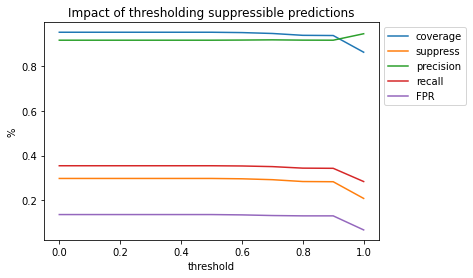

In [35]:
plt.plot(thresholds, coverage)
plt.plot(thresholds, suppress)
plt.plot(thresholds, precision)
plt.plot(thresholds, recall)
plt.plot(thresholds, fpr)
plt.title("Impact of thresholding suppressible predictions")
plt.xlabel("threshold")
plt.ylabel("%")
plt.legend(("coverage","suppress","precision","recall","FPR"), bbox_to_anchor=(1,1))
plt.show()